In [ ]:
import os
current_dir = os.getcwd()
print("Direccion actual:", current_dir)

os.chdir('/content/drive/MyDrive/Colab Notebooks/KHT-WCNN')
print("Nuevo directorio:", os.getcwd())

Direccion actual: /content
Nuevo directorio: /content/drive/MyDrive/Colab Notebooks/KHT-WCNN


In [ ]:
import pywt, cv2, time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Flatten, Dropout, Dense
#from keras.layers import Rescaling, RandomFlip, RandomBrightness, RandomContrast, RandomTranslation, RandomCrop

In [ ]:
from utils.manager_checkpointers import get_checkpoints
from utils.manage_csv_logger import get_csv_logger
from utils import export_metrics

In [ ]:
# Definir una función de normalización
def normalize_data(data):
    # Inicializar el escalador
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

In [ ]:
#Parametros para iniciales de imagenes
image_size = (300, 300)
n_imagenes = 108
#Inicializacion de las listas de datos
data = []
labels = []
labelsDWT =[]
DATA_DWT=[]
dataDWT_cA1, dataDWT_cA2, dataDWT_cA3 = ([] for _ in range(3))
dataDWT_cH3, dataDWT_cV3, dataDWT_cD3 = ([] for _ in range(3))
dataDWT_cH2, dataDWT_cV2, dataDWT_cD2 = ([] for _ in range(3))
dataDWT_cH1, dataDWT_cV1, dataDWT_cD1 = ([] for _ in range(3))

# Lista de categorías
dataset_dir = os.path.join("KTH-TIPS2-b")
categorias = os.listdir(dataset_dir)
print(f'Categorías: {categorias}')

#wavelets_prueba = ['haar', 'db10', 'sym2', 'coif1', 'bior1.1']
wavelet = 'bior1.1'
niveles1, niveles2, niveles3 = 1, 2, 3

Categorías: ['white_bread', 'wood', 'lettuce_leaf', 'cork', 'wool', 'aluminium_foil', 'cracker', 'brown_bread', 'cotton', 'linen', 'corduroy']


In [ ]:
# Cargar imágenes y asignar etiquetas
start_time = time.time()
for i, categoria in enumerate(categorias):
    categoria_path = os.path.join(dataset_dir, categoria)
    for muestra in os.listdir(categoria_path):
        muestra_path = os.path.join(categoria_path, muestra)
        for imagen_file in os.listdir(muestra_path)[:n_imagenes]:
            imagen_path = os.path.join(muestra_path, imagen_file)

            # Verificar si el archivo es una imagen
            if os.path.splitext(imagen_file)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp']:
                # Cargar y preprocesar la imagen con Keras (a escala de grises)
                img = image.load_img(imagen_path, target_size=image_size, color_mode="grayscale")
                img_array = image.img_to_array(img)
                # Agregar datos y etiquetas
                data.append(img_array)
                labels.append(i)
            else:
                print(f"Archivo no válido: {imagen_file}")
print(f'Datos cargados con exito con {len(data)} datos y {len(labels)} etiquetas')

# Información sobre la forma de los conjuntos de datos
#for i, categoria in enumerate(categorias):
#    print(f'Data {categoria.capitalize()}:', data[labels == i].shape)
for categoria in categorias:
    num_muestras = sum(1 for label in labels if label == categorias.index(categoria))
    print(f'Data {categoria.capitalize()}: ({num_muestras}, {data[labels == categorias.index(categoria)].shape[1:]})')

# Convertir a matrices NumPy
data = np.array(data, dtype=np.float64)
labels = np.array(labels)
print(f"Dimensiones de datos: {data.shape}")
print(f"Dimensiones de etiquetas: {labels.shape}")

end_time = time.time()
elapsed_time_up = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time_up:.2f} segundos")

Datos cargados con exito con 4752 datos y 4752 etiquetas
Data White_bread: (432, (300, 1))
Data Wood: (432, (300, 1))
Data Lettuce_leaf: (432, (300, 1))
Data Cork: (432, (300, 1))
Data Wool: (432, (300, 1))
Data Aluminium_foil: (432, (300, 1))
Data Cracker: (432, (300, 1))
Data Brown_bread: (432, (300, 1))
Data Cotton: (432, (300, 1))
Data Linen: (432, (300, 1))
Data Corduroy: (432, (300, 1))
Dimensiones de datos: (4752, 300, 300, 1)
Dimensiones de etiquetas: (4752,)
Tiempo transcurrido: 123.80 segundos


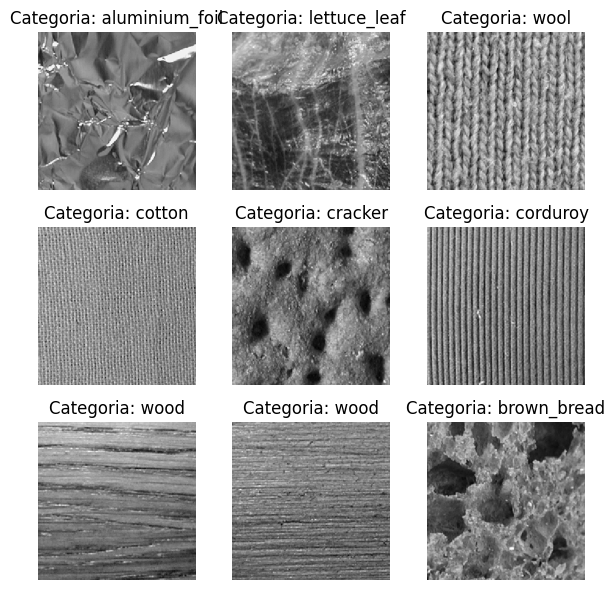

In [ ]:
n = 3
num_imagenes_total = n * n
indices_aleatorios = np.random.choice(len(data), num_imagenes_total, replace=False)
fig, axs = plt.subplots(n, n, figsize=(6, 6))
for i in range(n):
    for j in range(n):
        indice_imagen = indices_aleatorios[i * n + j]
        axs[i, j].imshow(data[indice_imagen][:, :, 0], cmap='gray')
        axs[i, j].set_title(f'Categoria: {categorias[labels[indice_imagen]]}')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Codificar las etiquetas a one-hot encoding
labels_or = to_categorical(labels, num_classes=11)
print(labels_or.shape)

#Aumento etiquetas en 4
for label in labels:
    repeated_labels = np.array([label] * 4)
    labelsDWT = np.concatenate((labelsDWT, repeated_labels))
print("Número de nuevas etiquetas:", len(labelsDWT))

(4752, 11)
Número de nuevas etiquetas: 19008


In [ ]:
#---------------Extraccion de caracteristicas Wavelet---------------#
start_time = time.time()

for imagen_array in data:
    if len(imagen_array.shape) == 3:
        imagen_array = imagen_array[:, :, 0]

    # Aplicar descomposición wavelet
    coeffs = pywt.wavedec2(imagen_array, wavelet, level=niveles1)
    cA=coeffs[0]

    DATA_DWT.append(cA)
    dataDWT_cA1.append(cA)

print('Descomposición de 1 nivel completada con éxito...')

for imagen_array in data:
    if len(imagen_array.shape) == 3:
        imagen_array = imagen_array[:, :, 0]

    # Aplicar descomposición wavelet
    coeffs = pywt.wavedec2(imagen_array, wavelet, level=niveles2)
    cA=coeffs[0]
    DATA_DWT.append(cA)
    dataDWT_cA2.append(cA)

print('Descomposición de 2 nivel completada con éxito...')

for imagen_array in data:
    if len(imagen_array.shape) == 3:
        imagen_array = imagen_array[:, :, 0]

    # Aplicar descomposición wavelet
    coeffs = pywt.wavedec2(imagen_array, wavelet, level=niveles3)
    (cA, (cH1, cV1, cD1), (cH2, cV2, cD2), (cH3, cV3, cD3)) = coeffs

    detalles1 = cv2.merge((cH1, cV1, cD1))

    dataDWT_cA3.append(cA)
    dataDWT_cH3.append(cH1)
    dataDWT_cV3.append(cV1)
    dataDWT_cD3.append(cD1)

    dataDWT_cH2.append(cH2)
    dataDWT_cV2.append(cV2)
    dataDWT_cD2.append(cD2)

    dataDWT_cH1.append(cH3)
    dataDWT_cV1.append(cV3)
    dataDWT_cD1.append(cD3)
    DATA_DWT.append(cA)
    DATA_DWT.append(cH1)
    DATA_DWT.append(cV1)
    DATA_DWT.append(cD1)
    DATA_DWT.append(cH2)
    DATA_DWT.append(cD2)

print('Descomposición de 3 nivel completada con éxito...')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")


Descomposición de 1 nivel completada con éxito...
Descomposición de 2 nivel completada con éxito...
Descomposición de 3 nivel completada con éxito...
Tiempo transcurrido: 24.29 segundos


In [ ]:
# Convertir listas a matrices NumPy
dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3 = map(np.array, (dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3))
#dataDWT_cA2, dataDWT_cH2, dataDWT_cV2, dataDWT_cD2 = map(np.array, (dataDWT_cA2, dataDWT_cH2, dataDWT_cV2, dataDWT_cD2))
#dataDWT_cA1, dataDWT_cH1, dataDWT_cV1, dataDWT_cD1 = map(np.array, (dataDWT_cA1, dataDWT_cH1, dataDWT_cV1, dataDWT_cD1))

In [ ]:
# Imprimir las dimensiones de cada matriz
print("Dimensiones de dataDWT_cA3:", dataDWT_cA3.shape)
#print("Dimensiones de dataDWT_cA2:", dataDWT_cA2.shape)
#print("Dimensiones de dataDWT_cA1:", dataDWT_cA1.shape)
#print("Data completa:", len(DATA_DWT))
#---------------------------------------------------------#
#dataDWT1=np.concatenate((dataDWT_cA1, dataDWT_cH1, dataDWT_cV1, dataDWT_cD1), axis=0)
#print("Dimensiones concatenadas", dataDWT1.shape)
#dataDWT2=np.concatenate((dataDWT_cA2, dataDWT_cH2, dataDWT_cV2, dataDWT_cD2), axis=0)
#print("Dimensiones concatenadas", dataDWT2.shape)
dataDWT3=np.concatenate((dataDWT_cA3, dataDWT_cH3, dataDWT_cV3, dataDWT_cD3), axis=0)
print("Dimensiones concatenadas", dataDWT3.shape)

Dimensiones de dataDWT_cA3: (4752, 38, 38)
Dimensiones concatenadas (19008, 38, 38)


In [ ]:
# Codificar las etiquetas a one-hot encoding
labels_DWT_oh = to_categorical(labelsDWT, num_classes=11)
print(labels_DWT_oh.shape)
print(labels_DWT_oh[5183])

# Entrenamiento y prueba
#X_train0, X_test0, y_train0, y_test0 = train_test_split(data, labels_or, test_size=0.20, random_state=42)
#X_train1, X_test1, y_train1, y_test1 = train_test_split(dataDWT1, labels_DWT_oh, test_size=0.20, random_state=42)
#X_train2, X_test2, y_train2, y_test2 = train_test_split(dataDWT2, labels_DWT_oh, test_size=0.20, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(dataDWT_cA3, labels_or, test_size=0.20, random_state=42)

# Definir los conjuntos de datos y sus nombres
#datasets = [X_train0, X_test0, y_train0, y_test0, X_train1, X_test1, y_train1, y_test1, X_train2, X_test2, y_train2, y_test2, X_train3, X_test3, y_train3, y_test3]
#dataset_names = ["X_train0", "X_test0", "y_train0", "y_test_0","X_train1", "X_test1", "y_train1", "y_test1", "X_train2", "X_test2", "y_train2", "y_test2", "X_train3", "X_test3", "y_train3", "y_test3"]

(19008, 11)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Imprimir el tamaño de cada conjunto de datos
# for dataset, name in zip(datasets, dataset_names):
#     print(f"Tamaño de {name}: {dataset.shape}")

# Aplicar la función de normalización utilizando map
#X_train_normalized = list(map(normalize_data, [X_train1, X_train2, X_train3]))
#X_train_normalized_reshaped = np.expand_dims(X_train_normalized[2], axis=-1)
#print("Forma original:", X_train_normalized[2].shape)
#print("Nueva forma:", X_train_normalized_reshaped.shape)
#X_test_normalized = list(map(normalize_data, [X_test1, X_test2, X_test3]))
#y_train_normalized = [y_train1, y_train2, y_train3]
#y_test_normalized = [y_test1, y_test2, y_test3]

X_train_normalized = normalize_data(X_train3)
X_train_normalized_reshaped = np.expand_dims(X_train_normalized, axis=-1)
print("Forma original:", X_train_normalized.shape)
print("Nueva forma:", X_train_normalized_reshaped.shape)
X_test_normalized = normalize_data(X_test3)
y_train_normalized = y_train3
y_test_normalized = y_test3

Forma original: (3801, 38, 38)
Nueva forma: (3801, 38, 38, 1)


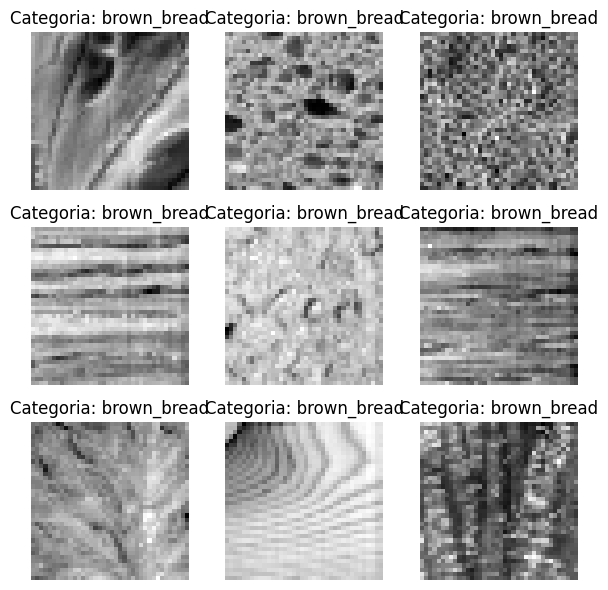

In [ ]:
n = 3
num_imagenes_total = n*n
idx_al = np.random.choice(len(X_train_normalized_reshaped), num_imagenes_total, replace=False)
fig, axs = plt.subplots(n, n, figsize=(6, 6))
for i in range(n):
    for j in range(n):
        idx_img = idx_al[i * n + j]
        axs[i, j].imshow(X_train_normalized_reshaped[idx_img][:, :, 0], cmap='gray')
        axs[i, j].set_title(f'Categoria: {categorias[labels[indice_imagen]]}')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# # Imprimir la forma de cada conjunto de datos normalizado
# for i, (X_train, X_test, y_train, y_test) in enumerate(zip(X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized), start=1):
#     print(f"Conjunto de datos {i}:")
#     print(f"X_train shape: {X_train.shape}")
#     print(f"X_test shape: {X_test.shape}")
#     print(f"y_train shape: {y_train.shape}")
#     print(f"y_test shape: {y_test.shape}")
#     print()
#-----------------Parametros de la red------------------------#
INIT_LR = 1e-3  # Valor inicial de learning rate.
epochs = 100  # Cantidad de iteraciones completas al conjunto de imágenes de entrenamiento
batch_size = 32  # Cantidad de imágenes que se toman a la vez en memoria
# img_width, img_height = 300, 300
# img_width1, img_height1 = 150, 150
# img_width2, img_height2 = 75, 75
# img_width3, img_height3 = 38, 38
img_shape = X_train_normalized_reshaped[0].shape
n_class=11
experimento = 1
dropout = 0.2
loss_funtion = 'categorical_crossentropy'
metric_acc = 'accuracy'

In [ ]:
#-------------Arquitectura del modelo CNN---------------------#
model = Sequential()
model.add(Input(shape=(img_shape)))
#model.add(Rescaling(1./255, name='Rescaling'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_1'))
#model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_2'))
#model.add(RandomBrightness(factor=0.2, name='Bringhtness'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_1'))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_3'))
#model.add(RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3),fill_mode="reflect", name='RandomTranslation'))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_4'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_2'))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_5'))
#model.add(RandomFlip("horizontal_and_vertical", seed=None, name='RandomFlip'))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', name='Conv2D_6'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_3'))
#model.add(Conv2D(512, (3,3), strides=1, padding='same', activation='relu', name='Conv2D_7'))
#model.add(Conv2D(512, (3,3), strides=1, padding='same', activation='relu', name='Conv2D_8'))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool_3'))
model.add(GlobalAveragePooling2D(name='GlobalAvgPool'))
#model.add(Flatten(name='Flatten'))
model.add(Dropout(0.3, name='Dropout'))
model.add(Dense(n_class, activation='softmax', name='Output'))

#Compilación del modelo
adam_optimizer = Adam(learning_rate=INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam_optimizer, loss=loss_funtion, metrics=[metric_acc])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 38, 38, 64)        640       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 19, 19, 64)        0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 19, 19, 128)       73856     
                                                                 
 Conv2D_4 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 10, 10, 128)       0         
                                                                 
 Conv2D_5 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 Conv2D_6 (Conv2D)           (None, 10, 10, 256)       5

In [ ]:
checkpoints = get_checkpoints(wavelet, experimento)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='max', restore_best_weights=True)
csv_logger = get_csv_logger(wavelet, experimento)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)

Checkpointers saved successfully.
CSVLogger saved successfully.


In [ ]:
# Generar el diagrama de la arquitectura
plot_model(model, to_file=f'plot_model/model_WCNN_arc2a-1-expe_{experimento}.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=150)

#print('Using real-time data augmentation.')
# Configuramos el generador de imágenes con las transformaciones deseadas
#datagen = ImageDataGenerator(
#    rotation_range=20,  # Rango de rotación aleatoria en grados
#     width_shift_range=0.2,  # Rango de traslación horizontal aleatoria
#     height_shift_range=0.2,  # Rango de traslación vertical aleatoria
#     shear_range=0.2,  # Rango de corte aleatorio
#     zoom_range=0.2,  # Rango de zoom aleatorio
#     horizontal_flip=True,  # Volteo horizontal aleatorio
#     fill_mode='nearest'  # Modo de llenado para valores fuera: de los límites de la imagen
#)

# Ajustamos el generador a los datos de entrenamiento
#datagen.fit(X_train_normalized_reshaped)

# modelo con data augmentation
start_time = time.time()
history = model.fit(X_train_normalized_reshaped, y_train_normalized, batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test_normalized, y_test_normalized),
                    shuffle=True,
                    callbacks=[checkpoints, csv_logger, reduce_lr])
# Tiempo de finalización del bloque de código
end_time = time.time()
elapsed_time_fit = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time_fit:.2f} segundos")
#------------------------------------------------------------#

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.1607 - accuracy: 0.1907
Epoch 1: accuracy improved from -inf to 0.19074, saving model to saves/checkpointer/bior1.1-experiment/model_FDM-accuracy-1.keras

Epoch 1: loss improved from inf to 2.16070, saving model to saves/checkpointer/bior1.1-experiment/model_FDM-loss-1.keras

Epoch 1: val_accuracy improved from -inf to 0.29653, saving model to saves/checkpointer/bior1.1-experiment/model_FDM-val_accuracy-1.keras

Epoch 1: val_loss improved from inf to 1.95739, saving model to saves/checkpointer/bior1.1-experiment/model_FDM-val_loss-1.keras
119/119 [==============================] - 15s 38ms/step - loss: 2.1607 - accuracy: 0.1907 - val_loss: 1.9574 - val_accuracy: 0.2965 - lr: 0.0010
Epoch 2/100
115/119 [===========================>..] - ETA: 0s - loss: 1.9010 - accuracy: 0.2777
Epoch 2: accuracy improved from 0.19074 to 0.28072, saving model to saves/checkpointer/bior1.1-experiment/model_FDM-accuracy-1.keras

Epoch

In [ ]:
#-------------Metricas de evalucion del modelo---------------#
params_dict = {
    "image_size": image_size,
    "image_size_DWT": img_shape,
    "n_imagenes": n_imagenes,
    "data_DWT": dataDWT_cA3.shape,
    "labels": labels_or.shape,
    "wavelet": wavelet,
    "nivel_DWT": niveles3,
    "INIT_LR": INIT_LR,
    "epochs": epochs,
    "batch_size": batch_size,
    "num_class": n_class,
    "experimento": experimento,
    "Dropout": dropout,
    "time-up": elapsed_time_up,
    "time-DWT": elapsed_time,
    "time-train": elapsed_time_fit
}

loss, accuracy = model.evaluate(X_test_normalized, y_test_normalized)
print(f'Precisión del modelo en los datos de prueba: {accuracy*100:.2f}% \n Funcion de perdida: {loss:.2f}')

# Predicciones del conjunto de prueba
predictions = model.predict(X_test_normalized)
y_pred_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test_normalized, axis=1)

export_metrics.save_parameters(params_dict, wavelet, experimento)
export_metrics.save_results(loss, accuracy, y_test_classes, y_pred_classes, wavelet, experimento)
export_metrics.plot_performance(history, wavelet, experimento)

# Calcular métricas de evaluación
accuracy = export_metrics.calculate_accuracy(y_test_classes, y_pred_classes)
precision = export_metrics.calculate_precision(y_test_classes, y_pred_classes)
conf_matrix = export_metrics.calculate_confusion_matrix(y_test_classes, y_pred_classes)
print(f'Exactitud: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print('Matriz de Confusión:')
print(conf_matrix)

30/30 [==============================] - 0s 4ms/step - loss: 0.3810 - accuracy: 0.9001
Precisión del modelo en los datos de prueba: 90.01% 
 Funcion de perdida: 0.38
30/30 [==============================] - 0s 3ms/step
Parameters saved successfully.
Results saved successfully.
Gráficas guardadas exitosamente.
Exactitud: 90.01%
Precision: 91.21%
Matriz de Confusión:
[[89  0  0  3  3  0  1  2  2  0  0]
 [ 1 69  0  0  0  0  0  0  9 13  0]
 [ 0  0 83  0  3  0  1  0  0  0  0]
 [ 0  0  0 67  3  0  1  5  0  0  0]
 [ 0  0  0  0 83  0  0  0  0  0  0]
 [ 0  0  0  0 10 73  0  4  0  0  0]
 [ 1  0  1  3  3  0 78  1  0  0  0]
 [ 0  0  0  0  0  0  0 94  0  0  0]
 [ 0  0  0  2  4  0  0  0 62  2  5]
 [ 0  0  0  0  2  0  0  0  5 74  1]
 [ 0  0  0  0  3  0  0  0  0  1 84]]
